In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from pathlib import Path
import shutil
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA
from sklearn import preprocessing
import plotly.graph_objects as go
import albumentations as albumentations
from visualize_attributes import * 
from utils import *

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "data/original_data")
products = os.listdir(data_path)
number_of_product = len(products)
number_of_product

15

(900, 900, 3)


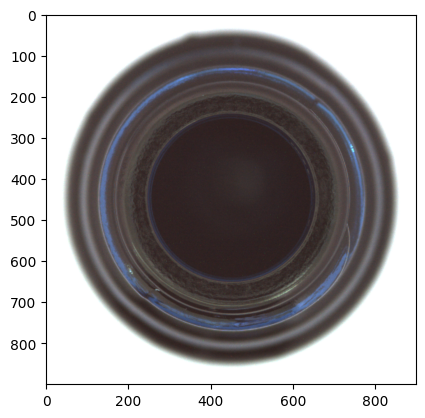

In [3]:
sample_image = cv2.imread(data_path + "/bottle/train/000.png", cv2.IMREAD_UNCHANGED)
print(sample_image.shape)
plt.imshow(sample_image)

/tmp/ipykernel_40550/974451610.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


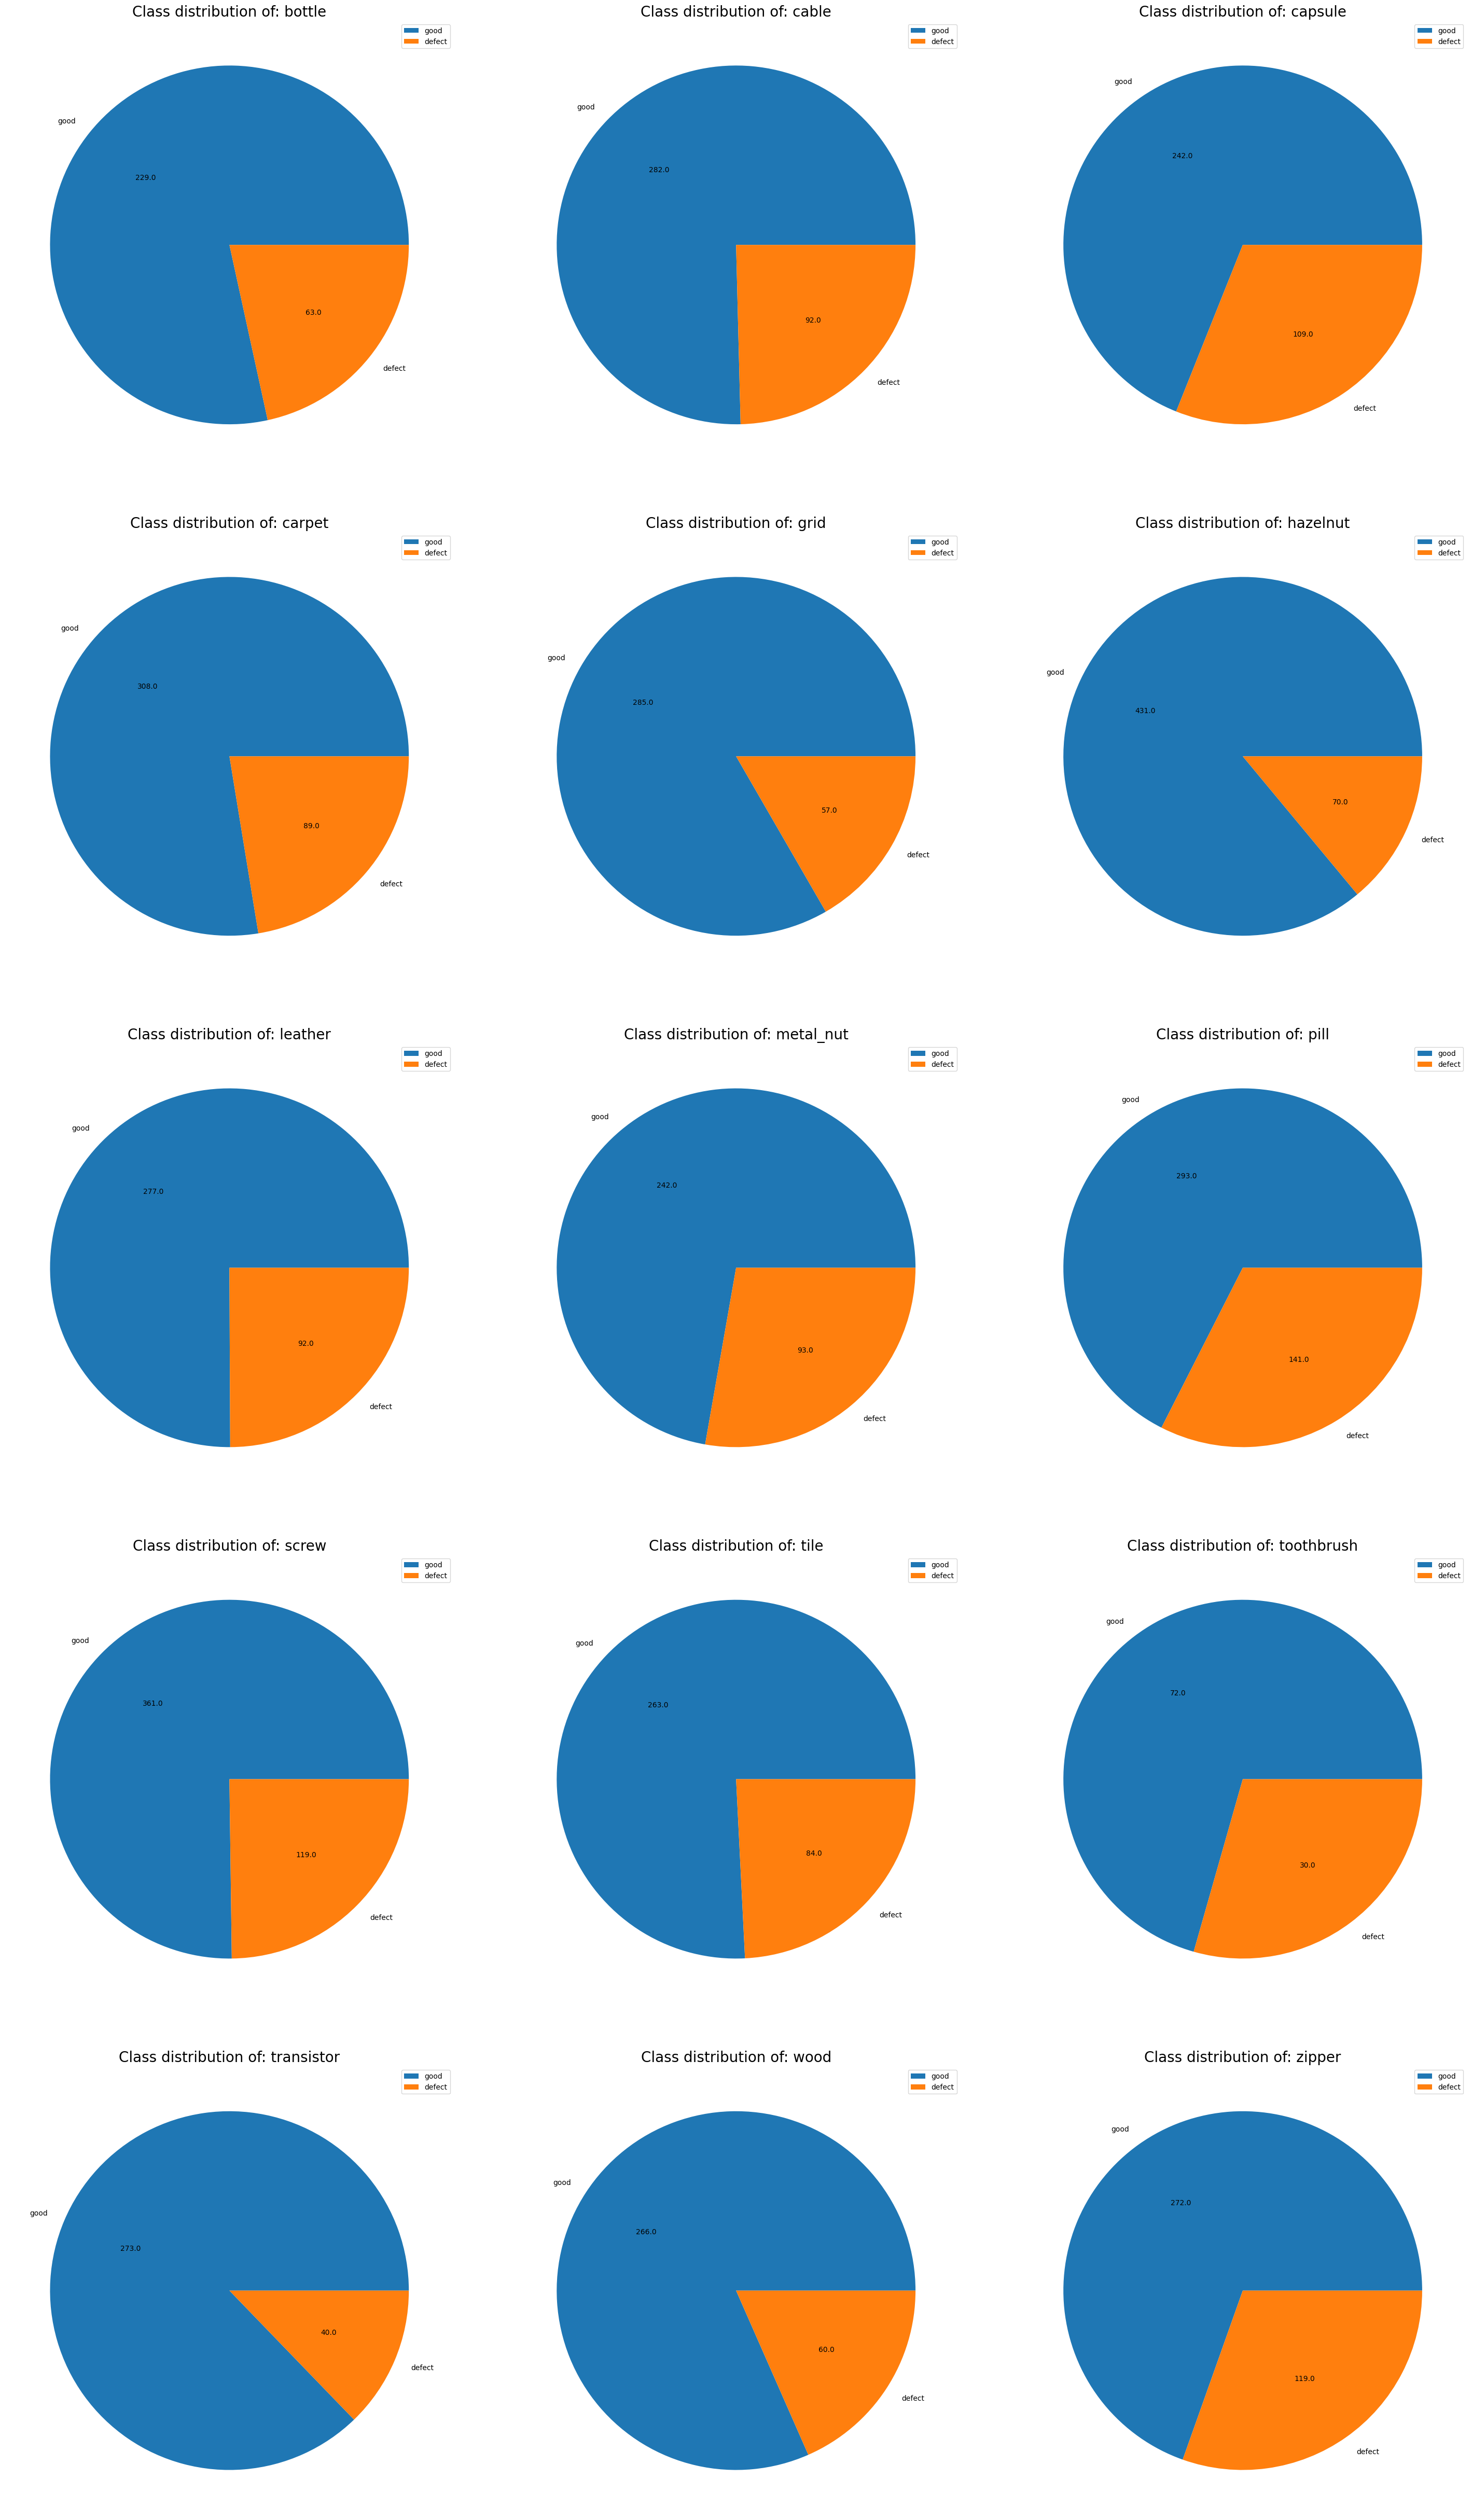

In [13]:
labels_dict = class_distribution(os.path.join(root_path, "data/unaugmented_grouped_data"))

fig, ax = plt.subplots(5, 3, figsize=(30, 50))
fig.tight_layout(pad=5)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
for i in range(number_of_product):
    product = products[i]
    product_count = labels_dict[product]
    labels, count = list(product_count.keys()), list(product_count.values())
    
    x, y = (int(i%3), int(i/3))
    ax[y, x].pie(count, labels=labels, autopct=lambda x: np.round(x/100.*np.sum(count), 0))
    ax[y, x].title.set_text('Class distribution of: '+ product)
    ax[y, x].legend()
fig.show()

### Augment images from test case

In [5]:
augment_data = False
if augment_data:
    augmented_data_path = os.path.join(root_path, "data/augmented_data")
    if not os.path.exists(augmented_data_path):
        os.mkdir(augmented_data_path)

    products = os.listdir(data_path)
    number_of_product = len(products)
    number_of_product

    generate_data = True

    # Augment pipeline:
    transform = albumentations.Compose([
        albumentations.Rotate(limit=5),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    ])

    for product in products:
        print(product)
        product_path = os.path.join(data_path, product)
        
        train_path = os.path.join(product_path, "train")
        test_path = os.path.join(product_path, "test")

        for case in os.listdir(test_path):
            if case != 'good':
                case_path = os.path.join(test_path, case)
                new_case_path = os.path.join(augmented_data_path + "/" + product + "/test/" + case)
                for image in os.listdir(case_path):
                    test_image = cv2.imread(os.path.join(case_path, image), cv2.COLOR_BGR2RGB)

                    # Transform each image 4 times, and save result each time
                    for i in range(4):
                        transformed_image = transform(image=test_image)['image']
                        transformed_image_name = image[:-4] + '_transformed_' + str(i) + '.png'
                        if generate_data:
                            cv2.imwrite(os.path.join(new_case_path, transformed_image_name), transformed_image)

    labels_dict = class_distribution(augmented_data_path)

    fig, ax = plt.subplots(5, 3, figsize=(30, 50))
    fig.tight_layout(pad=5)
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    for i in range(number_of_product):
        product = products[i]
        product_count = labels_dict[product]
        labels, count = list(product_count.keys()), list(product_count.values())
        
        x, y = (int(i%3), int(i/3))
        ax[y, x].pie(count, labels=labels, autopct=lambda x: np.round(x/100.*np.sum(count), 0))
        ax[y, x].title.set_text('Class distribution of: '+ product)
        ax[y, x].legend()
    fig.show()
    fig.savefig(root_path + '/Figure/augmented_each_class_embeddings.png')

### Group defects into one "bad" case

In [6]:
grouped_data_path = os.path.join(root_path, "data/unaugmented_grouped_data")
if not os.path.exists(grouped_data_path):
    os.mkdir(grouped_data_path)
move_image = True


for product in products:
    print(product)
    product_path = os.path.join(augmented_data_path, product) if augment_data else os.path.join(data_path, product)
        
    train_path = os.path.join(product_path, "train")
    test_path = os.path.join(product_path, "test")
    # print(os.path.exists(train_path), os.path.exists(test_path))
    
    dest_product_path = os.path.join(grouped_data_path, product)
    dest_good_path = os.path.join(dest_product_path, "train")
    dest_test_path = os.path.join(dest_product_path, "test")
    dest_defect_path = os.path.join(dest_test_path, "defect")
    for dest_path in [dest_product_path, dest_good_path, dest_test_path, dest_defect_path]:
        if not os.path.exists(dest_path):
            os.mkdir(dest_path)
        # else:
        #     print(dest_path)

    for image in os.listdir(train_path):
        image_path = os.path.join(train_path, image)
        new_image_path = os.path.join(dest_good_path, image)
        if move_image:
            shutil.copy(image_path, new_image_path)
    for case in os.listdir(test_path):
        if case == 'good':
            case_path = os.path.join(test_path, case)
            for image in os.listdir(case_path):
                image_path = os.path.join(case_path, image)
                if image in os.listdir(train_path):
                    image = image[:-4] + '_1.png'
                new_image_path = os.path.join(dest_good_path, image)
                if move_image:
                    shutil.copy(image_path, new_image_path)
        else:
            case_path = os.path.join(test_path, case)
            for image in os.listdir(case_path):
                image_path = os.path.join(case_path, image)
                new_image_name = case + '_' + image
                new_image_path = os.path.join(dest_defect_path, new_image_name)
                if move_image:
                    shutil.copy(image_path, new_image_path)

bottle
cable
capsule
carpet
grid
hazelnut
leather
metal_nut
pill
screw
tile
toothbrush
transistor
wood
zipper


### Group good cases and keep multiple bad cases

In [7]:
grouped_data_path = os.path.join(root_path, "data/unaugmented_multi_classed_grouped_data")
if not os.path.exists(grouped_data_path):
    os.mkdir(grouped_data_path)
move_image = True

for product in products:
    print(product)
    product_path = os.path.join(augmented_data_path, product) if augment_data else os.path.join(data_path, product)
        
    train_path = os.path.join(product_path, "train")
    test_path = os.path.join(product_path, "test")
    # print(os.path.exists(train_path), os.path.exists(test_path))
    
    dest_product_path = os.path.join(grouped_data_path, product)
    dest_good_path = os.path.join(dest_product_path, "train")
    dest_test_path = os.path.join(dest_product_path, "test")
    for dest_path in [dest_product_path, dest_good_path, dest_test_path]:
        if not os.path.exists(dest_path):
            os.mkdir(dest_path)
        # else:
        #     print(dest_path)

    for image in os.listdir(train_path):
        image_path = os.path.join(train_path, image)
        new_image_path = os.path.join(dest_good_path, image)
        if move_image:
            shutil.copy(image_path, new_image_path)
    for case in os.listdir(test_path):
        if case == 'good':
            case_path = os.path.join(test_path, case)
            for image in os.listdir(case_path):
                image_path = os.path.join(case_path, image)
                if image in os.listdir(train_path):
                    image = image[:-4] + '_1.png'
                new_image_path = os.path.join(dest_good_path, image)
                if move_image:
                    shutil.copy(image_path, new_image_path)
        else:
            case_path = os.path.join(test_path, case)
            dest_case_path = os.path.join(dest_test_path, case)
            if not os.path.exists(dest_case_path):
                os.mkdir(dest_case_path)
            for image in os.listdir(case_path):
                image_path = os.path.join(case_path, image)
                new_image_name = case + '_' + image
                new_image_path = os.path.join(dest_case_path, new_image_name)
                if move_image:
                    shutil.copy(image_path, new_image_path)

bottle
cable
capsule
carpet
grid
hazelnut
leather
metal_nut
pill
screw
tile
toothbrush
transistor
wood
zipper


### Unified train-test set split

In [3]:
target_path = os.path.join(root_path, 'data', 'augmented_train_test_split')
if not os.path.exists(target_path):
    os.mkdir(target_path)

for product in products:
    # Split from unaugmented-ungrouped data path for unnaive split
    product_path = os.path.join(root_path, "data/multi_classed_grouped_data", product)

    train_dict, test_dict, model_image_dict = generate_datasets_dict(product_path)

    product_target_path = os.path.join(target_path, product)
    if not os.path.exists(product_target_path):
        os.mkdir(product_target_path)

    for i in range(2):
        write_dict = [train_dict, test_dict][i]
        file_name = product + "_" + ['train_dict', 'test_dict'][i] + '.json'
        file_path = os.path.join(product_target_path, file_name)
        with open(file_path, 'w') as file:
            json.dump(write_dict, file)